# Lecture 39: Assignment 3 Discussion

---

1. **Single-Server Queueing Systems**

a. Implement the single-server queueing system $\text{ssq}(n, A, S)$ in Python for $n$ customers, given inter-arrival times $A$ and service times $S$, returning average delay $d$, average queue length $q$, and average server utilization $u$.

In [1]:
def ssq(n, A, S, silent=False):
    """
    This function simulates a single-server queueing system for n customers given their inter-arrival times - A, and service times - S

    Parameters
    ---
    n: int
        number of customers
    A: list[float]
        customer inter-arrival times
    S: list[float]
        customer service times
    silent=False: bool
        run in silence if True else display system

    Returns
    ---
    d: float
        average delay
    q: float
        average queue length
    u: float
        average utilization
    """
    # System Status
    t  = 0              # simulation clock
    z  = 0              # server status
    Q  = []             # queue
    # System Dynamics
    Ta = []             # customer arrival time
    Ts = []             # customer service initiation time
    Td = []             # customer depature time
    # System Log
    To = [0]            # event time (customer arrival/service initiation/departure time)
    Z  = [0]            # server status at event time
    J  = [0]            # queue length at event time
    # Initialization
    i  = -1             # index of last customer serviced
    j  = 0              # queue length
    k  = 0              # customers serviced
    ta = A[0]           # next arrival event time
    td = A[0] + S[0]    # next departure event time
    # Loop
    while k < n:
        if ta <= td:    # time jump to next customer arrival event
            e = 1
            t = ta
        else:           # time jump to next customer departure event
            e = -1
            t = td
        if e == 1:      # update system status for customer arrival
            To.append(t)
            Ta.append(t)
            if z == 0:
                e = 0
                i = i + 1
            else:
                Q.append(i+j+1)
                j = j + 1
            ta = round(ta + A[i+j+1], 1) if i+j+1 < len(A) else float('inf')
            Z.append(z)
            J.append(j)
            if not silent: print("Arrival      :     ", " ", "X", i , Q)
        elif e == -1:   # update system status for customer departure
            if not silent: print("Departure    :   ", i, "X", " ", Q)
            To.append(t)
            Td.append(t)
            if j == 0:
                z  = 0
                td = float('inf')
            else:
                e  = 0
                i  = Q.pop(0) 
                j  = j - 1
            Z.append(z)
            J.append(j)
            k = k + 1
        if e == 0:      # update system status for customer service initiation
            To.append(t)
            Ts.append(t)
            z  = 1
            td = t + S[i]
            Z.append(z)
            J.append(j)
            if not silent: print("Service      :     ", " ", "X", i, Q)
    T = [To[i]-To[i-1] for i in range(1,len(To))] + [0.0]
    d = round(sum([Ts[i] - Ta[i] for i in range(n)]) / n, 3)        # average delay
    q = round(sum([J[i] * T[i] for i in range(len(T))]) / t, 3)     # average queue length
    u = round(sum([Z[i] * T[i] for i in range(len(T))]) / t, 3)     # average utilization
    return d, q, u

b. Implement a Monte Carlo simulation $\text{mcs}(m, n, \lambda, \mu)$ in Python, simulating $m$ runs for a single-server queueing system with $n$ customers, exponential inter-arrivals (rate $\lambda$), and exponential service times (rate $\mu$).

In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulate(sims=1000, n=100, lam=0.8, mu=1.0):
    """
    Run Monte Carlo simulation of SSQ using exponential inter-arrivals and service times.
    
    Parameters
    ----------
    sims : int
        number of simulations (default=1000)
    n : int
        number of customers per run (default=100)
    lam : float
        arrival rate λ
    mu : float
        service rate μ
    
    Returns
    -------
    df : pandas.DataFrame
        Results with columns ['d','q','u']
    """
    # Random simulations
    results = []
    for k in range(sims):
        rng = random.Random(k)
        # Generate n+5 to avoid indexing issues in ssq
        A = [rng.expovariate(lam) for _ in range(n+5)]
        S = [rng.expovariate(mu) for _ in range(n+5)]
        d, q, u = ssq(n, A, S, silent=True)
        results.append((d, q, u))
    return pd.DataFrame(results, columns=["d","q","u"])

# Descriptive statistics
def describe_series(x: pd.Series):
    arr = np.asarray(x, dtype=float)
    mean = float(np.mean(arr))
    median = float(np.median(arr))
    rng = float(np.max(arr) - np.min(arr))
    sd = float(np.std(arr, ddof=1))
    iqr = np.percentile(arr, 75) - np.percentile(arr, 25)
    skew = np.mean((arr - mean)**3) / (sd**3) if sd > 0 else np.nan
    kurt = np.mean((arr - mean)**4) / (sd**4) - 3 if sd > 0 else np.nan
    return {
        "mean": mean, "median": median, "range": rng,
        "sd": sd, "iqr": iqr, "skewness": skew, "kurtosis": kurt
    }

def summarize_df(df: pd.DataFrame):
    return pd.DataFrame({col: describe_series(df[col]) for col in df.columns}).T
    

c. For a 1000-customer single-server queueing system with inter-arrival rate of 0.8 per minute and service rate of 1.0 per minutes, run 5000 simulations to

- report the measure of location, dispersion, and shape

- develop histogram plots

for average delay $d$, avereage queue length $q$, and average server utilization $u$.


Summary Statistics (1000 runs, n=100)

     mean  median   range      sd     iqr  skewness  kurtosis
d  3.9284  3.6485  17.869  1.3675  1.4980    2.4358   13.9735
q  3.1592  2.9195  15.685  1.1587  1.2512    2.5094   15.0328
u  0.7978  0.7970   0.252  0.0351  0.0470    0.1227    0.1329

Note: kurtosis is excess kurtosis.



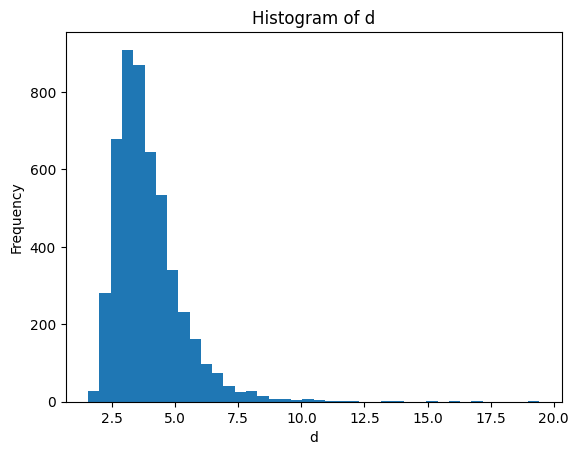

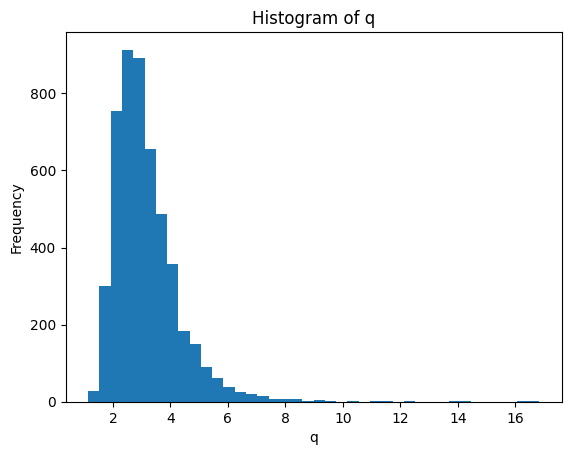

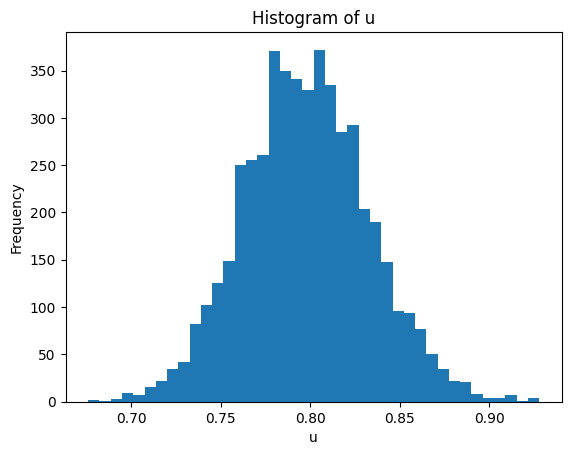

In [7]:
# Run and visualize
if __name__ == "__main__":
    df = simulate(sims=5000, n=1000, lam=0.8, mu=1.0)
    summary = summarize_df(df).round(4)
    print("\nSummary Statistics (1000 runs, n=100)\n")
    print(summary.to_string())
    print("\nNote: kurtosis is excess kurtosis.\n")
    
    # Histograms
    for metric in ["d","q","u"]:
        plt.figure()
        plt.hist(df[metric], bins=40)
        plt.title(f"Histogram of {metric}")
        plt.xlabel(metric)
        plt.ylabel("Frequency")
        plt.show()

d. For a 1000-customer single-server queueing system with inter-arrival rate $\lambda \in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]$ and service rate $\mu \in [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]$, use Symbolic Regression to explore the relation between average delay $d$, average queue length $q$, average server utilization $u$, and inter-arrival rate $\lambda$, service rate $\mu$. (Hint: Run Monte Carlo simulation for each $(\lambda, \mu)$ combination to produce a dataset of 100 single-server queueing systems, each with unique $(\lambda, \mu)$ and corresponding $d$, $q$, $u$. Then apply symbolic regression to explore the relation between the exogenous variables ($\lambda$, $\mu$, $\rho = \lambda / \mu$) and endogenous variables ($d$, $q$, $u$), each)

In [9]:
from pysr import PySRRegressor

L = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
M = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

data = []
for l in L:
    for m in M:
        df = simulate(sims=5000, n=1000, lam=l, mu=m)
        d = float(df['d'].mean())
        q = float(df['q'].mean())
        u = float(df['u'].mean())
        print(f"λ={l}, μ={m}, ρ = {round(l/m, 2)}, d={round(d, 2)}, q={round(q, 2)}, u={round(u, 2)}")
        data.append({"λ": l, "μ": m, "ρ": l / m, "d": d, "q": q, "u": u})

df = pd.DataFrame(data)

λ=0.1, μ=1.1, ρ = 0.09, d=0.09, q=0.01, u=0.09
λ=0.1, μ=1.2, ρ = 0.08, d=0.08, q=0.01, u=0.08
λ=0.1, μ=1.3, ρ = 0.08, d=0.06, q=0.01, u=0.08
λ=0.1, μ=1.4, ρ = 0.07, d=0.05, q=0.01, u=0.07
λ=0.1, μ=1.5, ρ = 0.07, d=0.05, q=0.0, u=0.07
λ=0.1, μ=1.6, ρ = 0.06, d=0.04, q=0.0, u=0.06
λ=0.1, μ=1.7, ρ = 0.06, d=0.04, q=0.0, u=0.06
λ=0.1, μ=1.8, ρ = 0.06, d=0.03, q=0.0, u=0.06
λ=0.1, μ=1.9, ρ = 0.05, d=0.03, q=0.0, u=0.05
λ=0.1, μ=2.0, ρ = 0.05, d=0.03, q=0.0, u=0.05
λ=0.2, μ=1.1, ρ = 0.18, d=0.2, q=0.04, u=0.18
λ=0.2, μ=1.2, ρ = 0.17, d=0.17, q=0.03, u=0.17
λ=0.2, μ=1.3, ρ = 0.15, d=0.14, q=0.03, u=0.15
λ=0.2, μ=1.4, ρ = 0.14, d=0.12, q=0.02, u=0.14
λ=0.2, μ=1.5, ρ = 0.13, d=0.1, q=0.02, u=0.13
λ=0.2, μ=1.6, ρ = 0.12, d=0.09, q=0.02, u=0.13
λ=0.2, μ=1.7, ρ = 0.12, d=0.08, q=0.02, u=0.12
λ=0.2, μ=1.8, ρ = 0.11, d=0.07, q=0.01, u=0.11
λ=0.2, μ=1.9, ρ = 0.11, d=0.06, q=0.01, u=0.11
λ=0.2, μ=2.0, ρ = 0.1, d=0.06, q=0.01, u=0.1
λ=0.3, μ=1.1, ρ = 0.27, d=0.34, q=0.1, u=0.27
λ=0.3, μ=1.2, ρ = 0.25, 

In [10]:
# Delay
X = df[["λ", "μ", "ρ"]].to_numpy()
y = df["d"].to_numpy()
model = PySRRegressor(
            niterations=1000,
            binary_operators=["+", "-", "*", "/"],
            maxsize=20,
            populations=40,
            progress=False,
        )

model.fit(X,y)

Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 6.930e+05
Progress: 3938 / 40000 total iterations (9.845%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.501e-01  0.000e+00  y = x₀
3           6.076e-01  1.679e-01  y = x₂ * 2.2502
5           9.564e-03  2.076e+00  y = x₂ / (x₁ - x₀)
7           4.093e-04  1.576e+00  y = x₂ / (x₁ + (x₀ * -0.98912))
9           9.313e-05  7.403e-01  y = ((-1.0783 / (x₂ + -1.0166)) + -1.078) / x₁
11          9.313e-05  5.573e-06  y = ((-1.0783 / ((x₀ / x₁) + -1.0166)) + -1.078) / x₁
13          9.313e-05  4.381e-06  y = ((-1.0783 / (((x₂ * x₁) / x₁) + -1.0166)) + -1.078) / ...
                                      x₁
17          9.313e-05  7.451e-08  y = ((((-1.0783 / (((x₂ * x₁) / x₁) + -1.0166)) + -1.078) ...
                                      / x₁) / x₀) 

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.501e-01  0.000e+00  y = x₀
3           6.076e-01  1.679e-01  y = x₂ * 2.2502
5           9.564e-03  2.076e+00  y = x₂ / (x₁ - x₀)
7           4.093e-04  1.576e+00  y = x₂ / (x₁ + (x₀ * -0.98912))
9           9.313e-05  7.403e-01  y = ((-1.0783 / (x₂ + -1.0166)) + -1.078) / x₁
11          3.860e-05  4.403e-01  y = (((-1.0933 / (x₂ + -1.019)) + -0.10239) / x₁) * x₂
13          2.656e-05  1.870e-01  y = (((-1.1184 / (x₂ + -1.021)) + -0.16788) * (x₂ / x₁)) -...
                                       -0.0060147
15          2.639e-05  3.272e-03  y = ((((-1.1182 / (x₂ + -1.021)) + -0.16935) * (x₂ / x₁)) ...
                                      - -0.0061224) * 1.0005
19          2.637e-05  1.429e-04  y = ((1.0005 - (-0.00025605 / x₀)) * (((-1.1182 / (x₂ + -1...
                                      .021)) + -0.16919) * (x₂ / x₁))) - -0.00

,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,None
,expression_spec,None
,niterations,1000
,populations,40
,population_size,27
,max_evals,None
,maxsize,20
,maxdepth,None
,warmup_maxsize_by,None


In [11]:
# Queue Length
X = df[["λ", "μ", "ρ"]].to_numpy()
y = df["q"].to_numpy()
model = PySRRegressor(
            niterations=1000,
            binary_operators=["+", "-", "*", "/"],
            maxsize=20,
            populations=40,
            progress=False,
        )

model.fit(X,y)

[ Info: Started!



Expressions evaluated per second: 6.460e+05
Progress: 3740 / 40000 total iterations (9.350%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.261e-01  0.000e+00  y = x₂
3           6.655e-01  1.081e-01  y = x₂ * 1.9482
5           3.880e-02  1.421e+00  y = x₂ / (x₁ - x₀)
7           9.121e-03  7.239e-01  y = (x₂ / (x₁ - x₀)) * x₀
9           5.813e-04  1.377e+00  y = (x₂ / (x₁ - (x₀ + -0.010469))) * x₀
11          1.227e-04  7.777e-01  y = ((x₂ / (x₁ - (x₀ + -0.016275))) * x₀) * 1.0446
13          6.733e-05  3.001e-01  y = (x₀ * ((x₂ / (x₁ - (x₀ + -0.018897))) - 0.021379)) * 1...
                                      .0692
15          5.490e-05  1.021e-01  y = (((x₂ / ((x₁ - x₀) + 0.019418)) * 1.0747) - (x₀ * 0.03...
                                      5301)) * x₀
17          4

[ Info: Final population:
[ Info: Results saved to:


,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,None
,expression_spec,None
,niterations,1000
,populations,40
,population_size,27
,max_evals,None
,maxsize,20
,maxdepth,None
,warmup_maxsize_by,None


  - outputs\20251030_115941_cCFLiT\hall_of_fame.csv


In [12]:
# Utilization
X = df[["λ", "μ", "ρ"]].to_numpy()
y = df["u"].to_numpy()
model = PySRRegressor(
            niterations=1000,
            binary_operators=["+", "-", "*", "/"],
            maxsize=20,
            populations=40,
            progress=False,
        )

model.fit(X,y)

[ Info: Started!



Expressions evaluated per second: 6.330e+05
Progress: 3727 / 40000 total iterations (9.318%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.626e-07  0.000e+00  y = x₂
3           7.661e-07  5.935e-02  y = x₂ * 0.99926
5           6.221e-07  1.041e-01  y = (x₂ * 0.99768) - -0.00076905
7           2.923e-07  3.778e-01  y = x₂ * ((x₂ * -0.009023) + 1.0044)
9           1.842e-07  2.309e-01  y = x₂ * (1.0024 - (x₂ * (x₂ * 0.0088272)))
11          8.187e-08  4.053e-01  y = ((0.0014764 / (x₀ - (x₁ / x₂))) + x₂) - -0.00053783
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expression

[ Info: Final population:
[ Info: Results saved to:


,model_selection,'best'
,binary_operators,"['+', '-', ...]"
,unary_operators,None
,expression_spec,None
,niterations,1000
,populations,40
,population_size,27
,max_evals,None
,maxsize,20
,maxdepth,None
,warmup_maxsize_by,None


The symbolic regression should render equations akin to,

$\text{E}[d] = \rho / (\mu - \lambda)$

$\text{E}[q] = \rho^2 / (1 - \rho)$

$\text{E}[u] = \rho$


---

2. **Cellular Automata for Single-Lane Car Following** 

a. Implement Nagel–Schreckenberg Model $\text{NaSchCA}(l, n, v, p, k, \text{seed})$ in Python for length of lattice $l$, number of vehicles $n$, maximum velocity $v$, stochastic braking probability $p$, and number of iterations $k$, with random number generator $\text{seed}$.

In [1]:
import numpy as np

def NaSchCA(l, n, v, p, k, seed):
    """
    Simulate the Nagel–Schreckenberg (NaSch) cellular automaton model of traffic flow
    on a single-lane ring road.

    Parameters
    ----------
    l : int
        Length of the lattice (number of discrete cells in the ring road).
    n : int
        Number of vehicles on the lattice.
    v : int
        Maximum velocity (cells per time step) allowed for a vehicle.
    p : float
        Stochastic braking probability (0 <= p <= 1).
    k : int
        Number of time steps (iterations) to simulate.
    seed : int
        Random seed for reproducibility of stochastic braking.

    Returns
    -------
    dict
        A dictionary containing:
        
        - ``X`` : ndarray of shape (n,)
            Final positions of vehicles on the lattice.
        - ``V`` : ndarray of shape (n,)
            Final velocities of vehicles.
        - ``Z`` : ndarray of shape (k, l)
            Space–time raster of the system, where each entry indicates
            the velocity of a vehicle occupying a cell, or -1 if empty.
        - ``f`` : float
            Mean flow over the simulation horizon, normalized by lattice length.
    """
    # Intialize
    rng = np.random.default_rng(seed)
    s = l // n
    X = np.arange(0, s*n, s) % l
    V = np.zeros(n, dtype=int)
    # Iterate    
    f = 0
    Z = np.full((k, l), -1, dtype=int)  # cell entry indicates speed of the vehicle occupying it; -1 if it is empty
    for t in range(k):
        Z[t, X] = V
        # Perception
        I = (np.arange(n) + 1) % n
        H = (X[I] - X - 1) % l
        # Decision-Making | Action | Environment Update
        ## Acceleration
        V = np.minimum(V + 1, v)
        ## Deceleration
        V = np.minimum(V, H)
        ## Stochastic Braking
        r = rng.random(n)
        K = (r < p) & (V > 0)
        V[K] -= 1
        X = (X + V) % l
        f += V.sum() / (k * l)
    return {"X": X, "V": V, "Z": Z, "f": f}

b. For a lattice with 300 cells, 60 vehicles, each with maximum velocity of 5 cells per unit time and stochastic braking probability of 20%, run 400 iterations in time to create a time-space occupancy diagram.

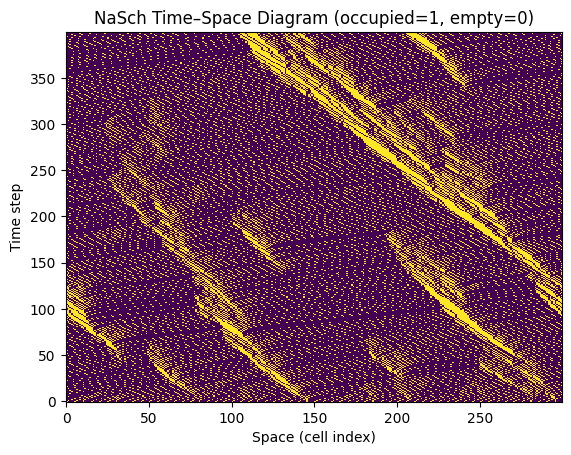

In [2]:
# Time–space occupancy diagram
import matplotlib.pyplot as plt

# Input Parameters
l = 300
n = 60
v = 5
p = 0.2
k = 400
seed = 5540

# Output
R = NaSchCA(l, n, v, p, k, seed)
Z = (R["Z"] >= 0).astype(int)

# Plot
plt.figure()
plt.imshow(Z, aspect='auto', origin='lower', interpolation='nearest')
plt.xlabel("Space (cell index)")
plt.ylabel("Time step")
plt.title("NaSch Time–Space Diagram (occupied=1, empty=0)")
plt.show()


c. Develop the fundamental flow diagram (flow vs density) relationship for this single-lane traffic.

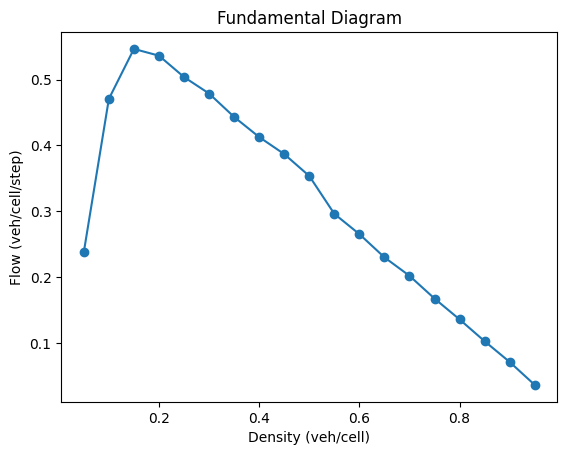

In [3]:
# Fundamental diagram (flow vs density) via density sweep
import numpy as np
import matplotlib.pyplot as plt

# Input Parameters
l = 300
n = 60
v = 5
p = 0.2
k1 = 300
k2 = 600
seed = 0

D = np.linspace(0.05, 0.95, 19)
F = []

for d in D:
    n = max(1, int(round(d*l)))
    _ = NaSchCA(l, n, v, p, k1, seed)
    R = NaSchCA(l, n, v, p, k2, seed)
    F.append(R["f"])

plt.figure()
plt.plot(D, F, marker='o')
plt.xlabel("Density (veh/cell)")
plt.ylabel("Flow (veh/cell/step)")
plt.title("Fundamental Diagram")
plt.show()